# Benchmarking with sktime

The benchmarking modules allows you to easily orchestrate benchmarking experiments in which you want to compare the performance of one or more algorithms over one or more data sets. It also provides a number of statistical tests to check if observed performance differences are statistically significant.

The benchmarking modules is based on [mlaut](https://github.com/alan-turing-institute/mlaut).

## Preliminaries

In [1]:
# import required functions and classes
import os

from sklearn.metrics import accuracy_score

from sktime.benchmarking.data import UEADataset, make_datasets
from sktime.benchmarking.evaluation import Evaluator
from sktime.benchmarking.metrics import PairwiseMetric
from sktime.benchmarking.orchestration import Orchestrator
from sktime.benchmarking.results import HDDResults
from sktime.benchmarking.strategies import TSCStrategy
from sktime.benchmarking.tasks import TSCTask
from sktime.classification.interval_based import (
    RandomIntervalSpectralForest,
    TimeSeriesForestClassifier,
)
from sktime.series_as_features.model_selection import PresplitFilesCV

### Set up paths

In [2]:
# set up paths to data and results folder
import sktime

DATA_PATH = os.path.join(os.path.dirname(sktime.__file__), "datasets/data")
RESULTS_PATH = "results"

### Create pointers to datasets on hard drive
Here we use the `UEADataset` which follows the [UEA/UCR format](http://www.timeseriesclassification.com) and some of the time series classification datasets included in sktime.

In [3]:
# Create individual pointers to dataset on the disk
datasets = [
    UEADataset(path=DATA_PATH, name="ArrowHead"),
    UEADataset(path=DATA_PATH, name="ItalyPowerDemand"),
]

In [4]:
# Alternatively, we can use a helper function to create them automatically
datasets = make_datasets(
    path=DATA_PATH, dataset_cls=UEADataset, names=["ArrowHead", "ItalyPowerDemand"]
)

### For each dataset, we also need to specify a learning task
The learning task encapsulate all the information and instructions that define the problem we're trying to solve. In our case, we're trying to solve classification tasks and the key information we need is the name of the target variable in the data set that we're trying to predict. Here all tasks are the same because the target variable has the same name in all data sets.

In [6]:
tasks = [TSCTask(target="target") for _ in range(len(datasets))]

### Specify learning strategies
Having set up the data sets and corresponding learning tasks, we need to define the algorithms we want to evaluate and compare.

In [7]:
# Specify learning strategies
strategies = [
    TSCStrategy(TimeSeriesForestClassifier(n_estimators=10), name="tsf"),
    TSCStrategy(RandomIntervalSpectralForest(n_estimators=10), name="rise"),
]

<ipython-input-7-94f673184319>:4: FutureWarning: Call to deprecated class RandomIntervalSpectralForest. (RandomIntervalSpectralForest will be moved or removed in v0.10.0, to be replaced by the correctly named RandomIntervalSpectralEnsemble) -- Deprecated since version 0.8.1.
  TSCStrategy(RandomIntervalSpectralForest(n_estimators=10), name="rise"),


### Set up a results object
The results object encapsulates where and how benchmarking results are stored, here we choose to output them to the hard drive.

In [8]:
# Specify results object which manages the output of the benchmarking
results = HDDResults(path=RESULTS_PATH)

## Run benchmarking
Finally, we pass all specifications to the orchestrator. The orchestrator will automatically train and evaluate all algorithms on all data sets and write out the results.

In [9]:
# run orchestrator
orchestrator = Orchestrator(
    datasets=datasets,
    tasks=tasks,
    strategies=strategies,
    cv=PresplitFilesCV(),
    results=results,
)
orchestrator.fit_predict(save_fitted_strategies=False, overwrite_predictions=True)

/opt/conda/lib/python3.8/site-packages/sktime/utils/data_io.py:63: FutureWarning: This function has moved to datasets/_data_io, this version will be removed in V0.10
  warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:82: FutureWarning: Call to deprecated class RandomIntervalSpectralForest. (RandomIntervalSpectralForest will be moved or removed in v0.10.0, to be replaced by the correctly named RandomIntervalSpectralEnsemble) -- Deprecated since version 0.8.1.
  new_object = klass(**new_object_params)
/opt/conda/lib/python3.8/site-packages/sktime/utils/data_io.py:63: FutureWarning: This function has moved to datasets/_data_io, this version will be removed in V0.10
  warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:82: FutureWarning: Call to deprecated class RandomIntervalSpectralForest. (RandomIntervalSpectralForest will be moved or removed in v0.10.0, to be replaced by the correctly named RandomIntervalSpectralEnsemble) -- Deprecated since version 0.8.1.
  new_ob

## Evaluate and compare results
Having run the orchestrator, we can evaluate and compare the prediction strategies.

In [10]:
evaluator = Evaluator(results)
metric = PairwiseMetric(func=accuracy_score, name="accuracy")
metrics_by_strategy = evaluator.evaluate(metric=metric)
metrics_by_strategy.head()

,strategy,accuracy_mean,accuracy_stderr
0,rise,0.795160,0.021697
1,tsf,0.817707,0.020778


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'accuracy by strategy'}, xlabel='strategies', ylabel='accuracy'>)

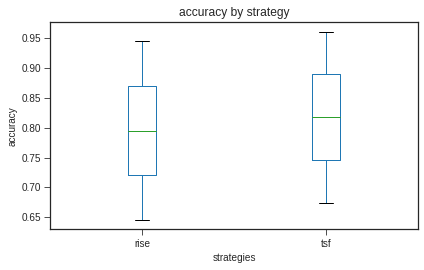

In [13]:
evaluator.plot_boxplots()

The evaluator offers a number of additional methods for evaluating and comparing strategies, including statistical hypothesis tests and visualisation tools, for example:

In [11]:
evaluator.rank()

,strategy,accuracy_mean_rank
0,rise,2.0
1,tsf,1.0


Currently, the following functions are implemented:

* `evaluator.plot_boxplots()`
* `evaluator.ranks()`
* `evaluator.t_test()`
* `evaluator.sign_test()`
* `evaluator.ranksum_test()`
* `evaluator.t_test_with_bonferroni_correction()`
* `evaluator.wilcoxon_test()`
* `evaluator.friedman_test()`
* `evaluator.nemenyi()`